# **Download and prepare assets**

In [1]:
import os, sys
if not os.path.isdir('/content/UAVPatches'):
  !git clone -q https://github.com/farhadinima75/UAVPatches.git
os.chdir('/content/UAVPatches')
sys.path.append('/content/UAVPatches')

#Install requirements
!pip3 install -q -r Requirements.txt

#Download HardNet and Brown6 descriptor weights
!wget -q -O ./Pretrained/HardNet.pth https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty/checkpoint_liberty_no_aug.pth
!wget -q -O ./Pretrained/Brown6.pth https://github.com/DagnyT/hardnet/raw/master/pretrained/6Brown/hardnetBr6.pth

     |████████████████████████████████| 50.4 MB 60 kB/s 
     |████████████████████████████████| 56.3 MB 1.6 MB/s 
     |████████████████████████████████| 367 kB 32.9 MB/s 
     |████████████████████████████████| 2.4 MB 31.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# **Matching 2 UAV images with UAVPatches+, UAVPatches, HardNet and SIFT**

Please select 2 images (left and right image).


Saving IMG_3714.JPG to IMG_3714.JPG
Saving IMG_3733.JPG to IMG_3733.JPG
Matching images with SIFT...  Done.
Matching images with HardNet...  Done.
Matching images with Brown6...  Done.
Matching images with UAVPatches...  Done.
Matching images with UAVPatches+...  Done.


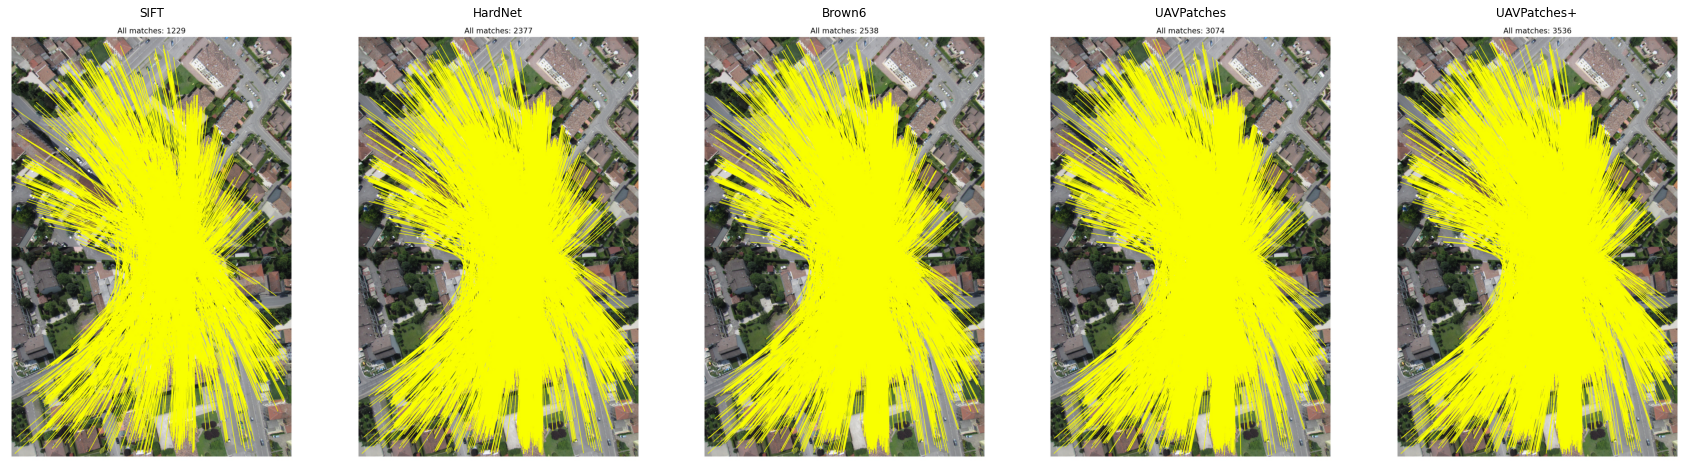

In [1]:
import os, sys, torch, cv2, time
os.chdir('/content/UAVPatches')
sys.path.append('/content/UAVPatches')
from Utils.Matching import *
from Utils.Model import HardNet
from Utils.Visualize import draw_matches
from google.colab import files
from matplotlib import pyplot as plt

UAVPatchesPlusDesc = HardNet().eval()
UAVPatchesPlusDesc.load_state_dict(torch.load('/content/UAVPatches/Pretrained/UAVPatches+.pth', map_location=torch.device('cpu'))['state_dict'])
UAVPatchesDesc = HardNet().eval()
UAVPatchesDesc.load_state_dict(torch.load('/content/UAVPatches/Pretrained/UAVPatches.pth', map_location=torch.device('cpu'))['state_dict'])
HardnetModel = HardNet().eval()
HardnetModel.load_state_dict(torch.load('/content/UAVPatches/Pretrained/HardNet.pth', map_location=torch.device('cpu'))['state_dict'])
Brown6Model = HardNet().eval()
Brown6Model.load_state_dict(torch.load('/content/UAVPatches/Pretrained/Brown6.pth', map_location=torch.device('cpu'))['state_dict'])

def UploadImages():
  print('Please select 2 images (left and right image).')
  Images = '/content/UAVPatches/Images'
  os.makedirs(Images, exist_ok=True)
  os.chdir(Images)
  uploaded = files.upload()
  return os.path.join(Images, list(uploaded.keys())[0]), os.path.join(Images, list(uploaded.keys())[1])

def Match2Image(DescName):
  if   DescName == 'UAVPatches+': Desc = UAVPatchesANDPlus(UAVPatchesPlusDesc)
  elif DescName == 'UAVPatches': Desc = UAVPatchesANDPlus(UAVPatchesDesc)
  elif DescName == 'HardNet': Desc = HardNetDesc(HardnetModel)
  elif DescName == 'Brown6': Desc = HardNetDesc(Brown6Model)
  else:  Desc = SIFT()
  MatchInit = TwoViewMatcher(detector=cv2.SIFT_create(TotalKeyPoints), descriptor=Desc,
                             matcher=SNNMMatcher(SNN_Tr), geom_verif=degensac_Verifier(DEGENSAC_Tr))
  MatchOut = MatchInit.verify(img1, img2)
  draw_matches(MatchOut['match_kpts1'], MatchOut['match_kpts2'],
               img1, img2, path=os.path.join(OutputDir, DescName), figsize=(8,13), color=(250,255,0), vert=True, R=6)
  
'''
#########################################################
################ Main ###################################
#########################################################
'''

TotalKeyPoints = 50000
SNN_Tr = 0.7        #### Set this parameter to 0.9 for getting paper results. 0.7 is the proposed value in SIFT (Lowe, 2004).
DEGENSAC_Tr = 5.0   #### Set this parameter to 0.5 for getting paper results.
Descriptors = ['SIFT', 'HardNet', 'Brown6', 'UAVPatches', 'UAVPatches+']


OutputDir = '/content/UAVPatches/Outputs'
os.makedirs(OutputDir, exist_ok=True)

img1, img2 = UploadImages()

Fig, Axs = plt.subplots(1, len(Descriptors), figsize=(30,20))
for i, DName in enumerate(Descriptors):
  print('Matching images with {}...  '.format(DName), end='')
  Match2Image(DName)
  print('Done.')
  if len(Descriptors) == 1: Axs.imshow(plt.imread(os.path.join(OutputDir, DName) + '.JPG')); Axs.set_title(DName)
  else: Axs[i].imshow(plt.imread(os.path.join(OutputDir, DName) + '.JPG')); Axs[i].set_title(DName); Axs[i].axis('off')
plt.show()
Fig.savefig(os.path.join(OutputDir, 'OutAll.png'), dpi=300, bbox_inches='tight')